# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data was provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891221 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to make cleaning decisions during this stage of the project. First of all, I assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object.Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. Investigate how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
col_names = azdias.columns
missing_natural = []
missing_code = []
missing_total = []
for col_name in col_names:
    values = feat_info[feat_info.attribute==col_name].missing_or_unknown.values[0]
    values = values.split('[')[1].split(']')[0].split(',')
    missing_natural_no = azdias[col_name].isnull().sum()
    missing_natural.append(missing_natural_no)
    if (values[0]!=''):
        if azdias[col_name].dtype=='object':
            azdias[col_name].replace(values,np.nan,inplace=True)
        else:
            values = list(map(int, values))
            azdias[col_name].replace(values,np.nan,inplace=True)
        
    missing_total_no = azdias[col_name].isnull().sum()
    missing_code.append((missing_total_no-missing_natural_no))
    missing_total.append(missing_total_no)

df = {'col_name': col_names,'missing natural':missing_natural,'missing code':missing_code,'missing total': missing_total}
missing = pd.DataFrame(df)

In [6]:
missing.head()

,col_name,missing code,missing natural,missing total
0,AGER_TYP,685843,0,685843
1,ALTERSKATEGORIE_GROB,2881,0,2881
2,ANREDE_KZ,0,0,0
3,CJT_GESAMTTYP,0,4854,4854
4,FINANZ_MINIMALIST,0,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. 

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#missing['total'] = missing['missing code'] + missing['missing natural']
missing['ratio'] = missing['missing total']/azdias.shape[0]

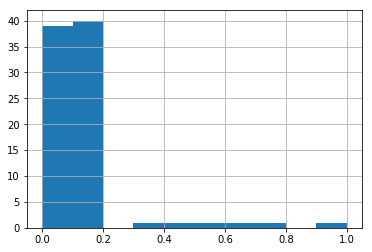

In [8]:
# Investigate patterns in the amount of missing data in each column.
missing['ratio'].hist();

In [9]:
# The oulier columns
# There are total 6 outlier columns
col_outliers = missing[missing.ratio>0.2].col_name
col_outliers

0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: col_name, dtype: object

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(col_outliers,axis=1,inplace=True)
len(azdias.columns)

79

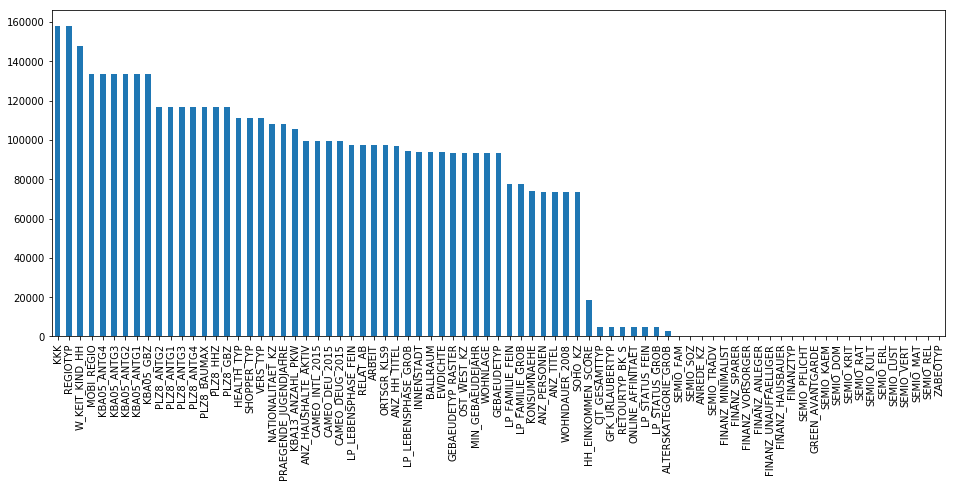

In [11]:
#Visulize the missing value pattern of azdias with outlier columns removed
azdias.isnull().sum().sort_values(ascending=False).plot.bar(figsize=(16,6))

#### Discussion 1.1.2: Assess Missing Data in Each Column
From the histgram of the missing value of each column, I find most columns have less than 200000 missing values, but there are 10 columns have more than 200000 missing values. These columns are:
'AGER_TYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'TITEL_KZ', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KK_KUNDENTYP', 'KBA05_BAUMAX'. These 10 columns are removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

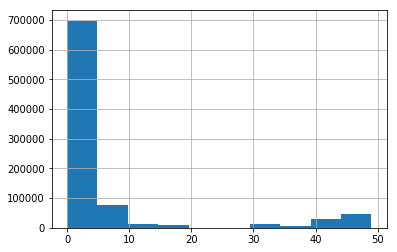

In [12]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis=1)
missing_row.hist();

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def divide_rows(rows, h):
    group1 = []
    group2 = []
    for x in range(len(rows)):
        if rows[x]>=h:
            group1.append(x)
        else:
            group2.append(x)
    return(group1,group2)
rows1,rows2 = divide_rows(missing_row,20)

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
df1 = azdias.iloc[rows1]
df2 = azdias.iloc[rows2]
print(df1.shape,df2.shape)

(94144, 79) (797077, 79)


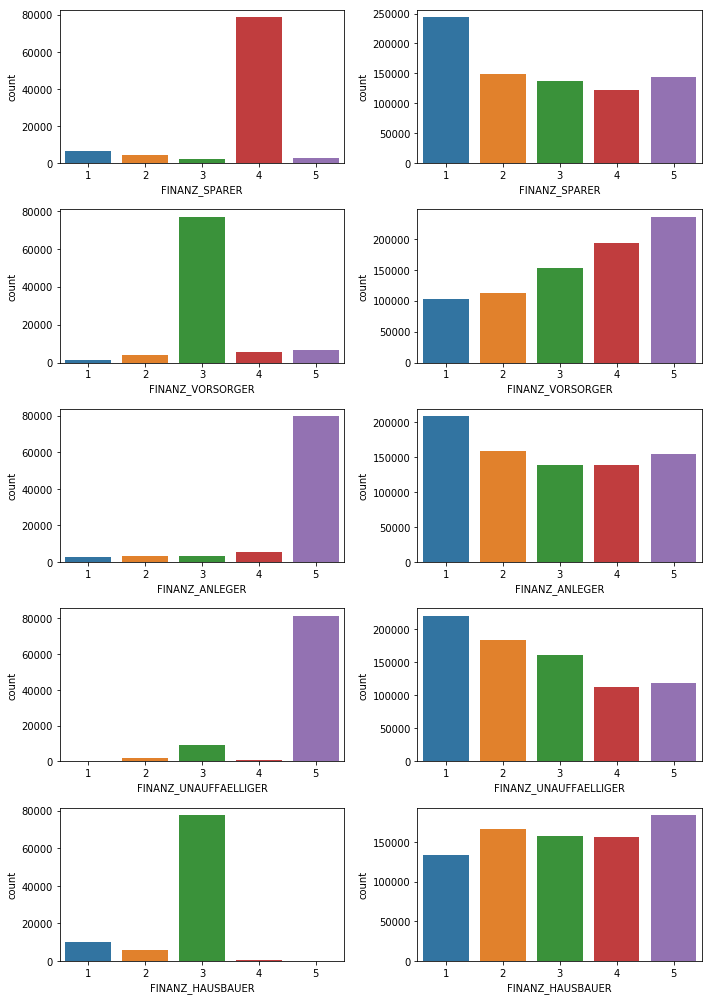

In [15]:
columns_cmp = missing[missing['missing total']==0].col_name.values[2:7]
i=1
figure = plt.figure(figsize=(10,14))
for col_name in columns_cmp:
    ax = plt.subplot(5,2,i)
    sns.countplot(x=col_name,data=df1,ax=ax)
    ax = plt.subplot(5,2,i+1)
    sns.countplot(x=col_name,data=df2,ax=ax,)
    i+=2
plt.tight_layout()

#### Discussion 1.1.3: Assess Missing Data in Each Row
From the bar charts I could conclued that the data with lots of misssing values are qualitatively different from data with few or no missing values. I will note the data with more missing values as special and revisit these data later on.

### Step 1.2: Select and Re-Encode Features

Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

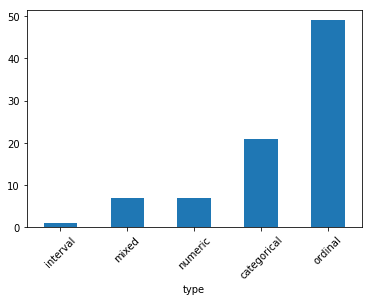

In [16]:
# How many features are there of each data type?
feat_info.groupby('type').attribute.count().sort_values().plot(kind='bar',rot=45);

#### Step 1.2.1: Re-Encode Categorical Features

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
col_categorical = feat_info[feat_info['type']=='categorical'].attribute.values
cols = [x for x in col_categorical if x in df2.columns]
for col  in cols:
    print(col, df2[col].unique())

ANREDE_KZ [2 1]
CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP [1 6 5 2 4 3]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [  1.   3.   2.  nan]
SHOPPER_TYP [  3.   2.   1.   0.  nan]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
ZABEOTYP [5 3 4 1 6 2]
GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


Column 'OST_WEST_KZ' is the only one that takes the non-numeric values. It will be re-encoded.

In [18]:
# Re-encode categorical variable(s) to be kept in the analysis.
df2.OST_WEST_KZ = df2.OST_WEST_KZ.apply(lambda x: 1 if x=='W' else 0)

In [19]:
df2.drop('CAMEO_DEU_2015',axis=1,inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features
1. Feature 'OST_WEST_KZ' has two values: 'W' and 'O". I use binary encoding to code 'W' to 1 and 'O' to  0.
2. Since 'CAMEO_DEU_2015' is a more detailed scale and a rough scale is given in 'CAMEO_DEUG_2015', I drop 'CAMEO_DEU_2015' directly.
3. For other categorical features, I leave them untouched because they are numerical already.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

#### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [20]:
gm_dict = {
    1.0: [40,'M'],
    2.0: [40,'A'],
    3.0: [50,'M'],
    4.0: [50,'A'],
    5.0: [60,'M'],
    6.0: [60,'A'],
    7.0: [60,'A'],
    8.0: [70,'M'],
    9.0: [70,'A'],
    10.0: [80,'M'],
    11.0: [80,'A'],
    12.0: [80,'M'],
    13.0: [80,'A'],
    14.0: [90,'M'],
    15.0: [90,'A']
}
df2.loc[:,'decade'] = np.nan
df2.loc[:,'movement'] = np.nan
df2.loc[df2.PRAEGENDE_JUGENDJAHRE.notnull(),['decade']] = df2[df2.PRAEGENDE_JUGENDJAHRE.notnull()].\
                                                          PRAEGENDE_JUGENDJAHRE.\
                                                          apply(lambda x:gm_dict[x][0])
df2.loc[df2.PRAEGENDE_JUGENDJAHRE.notnull(),['movement']] = df2[df2.PRAEGENDE_JUGENDJAHRE.notnull()].\
                                                            PRAEGENDE_JUGENDJAHRE.\
                                                            apply(lambda x:gm_dict[x][1])
df2.loc[:,'movement'] = df2.movement.apply(lambda x: 1 if x=='M' else 0)

#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

In [21]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df2.loc[:,'wealth'] = np.nan
df2.loc[:,'life_stage'] = np.nan
df2.loc[df2.CAMEO_INTL_2015.notnull(),'wealth'] = df2[df2.CAMEO_INTL_2015.notnull()].\
                                                  CAMEO_INTL_2015.astype('int').\
                                                  apply(lambda x: x//10)
df2.loc[df2.CAMEO_INTL_2015.notnull(),'life_stage'] = df2[df2.CAMEO_INTL_2015.notnull()].\
                                                  CAMEO_INTL_2015.astype('int').\
                                                  apply(lambda x: x%10)

In [22]:
mixed_feat = feat_info[feat_info.type=='mixed'].attribute
mixed_feat

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [23]:
df2.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN' ],axis=1,inplace=True)
df2.columns.shape

(78,)

#### Discussion 1.2.2: Engineer Mixed-Type Features
1. Using 'PRAEGENDE_JUGENDJAHRE' to create two new features: 'decade' and 'movement'.  The range of decade is from 40 to 90. The feature of 'movement' has two values: 'Mainstream' and 'Avantgarde', which are encoded as 1 and 0,respectively.
2. Using 'CAMEO_INTL_2015' to create two new features: 'wealth' and 'life_stage'.
3. 'LP_LEBENSPHASE_GROB' and 'LP_LEBENSPHASE_FEIN' are life stage in rough scale and fine scale. They are redundent features of 'life_stage' and I removed these features from the dataset.
4. I keep the all ther other mixed features.

### Step 1.3: Create a Cleaning Function
In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [24]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    col_names = df.columns
    for col_name in col_names:
        values = feat_info[feat_info.attribute==col_name].missing_or_unknown.values[0]
        values = values.split('[')[1].split(']')[0].split(',')
        if (len(values)>1) | (values[0]!=''):
            if df[col_name].dtype=='object':
                df[col_name].replace(values,np.nan,inplace=True)
            else:
                values = list(map(int, values))
                df[col_name].replace(values,np.nan,inplace=True)
    
    # remove selected columns and rows, ...
    df.drop(col_outliers,axis=1,inplace=True)
    
    missing_row = df.isnull().sum(axis=1)
    _,row_idx = divide_rows(missing_row,20)
    df = df.iloc[row_idx]
    
    # select, re-encode, and engineer column values.
    df.OST_WEST_KZ = df.OST_WEST_KZ.apply(lambda x: 1 if x=='W' else 0)
    df.drop('CAMEO_DEU_2015',axis=1,inplace=True)
    
    df.loc[:,'decade'] = np.nan
    df.loc[:,'movement'] = np.nan
    df.loc[df.PRAEGENDE_JUGENDJAHRE.notnull(),['decade']] = df[df.PRAEGENDE_JUGENDJAHRE.notnull()].\
                                                              PRAEGENDE_JUGENDJAHRE.\
                                                              apply(lambda x:gm_dict[x][0])
    df.loc[df.PRAEGENDE_JUGENDJAHRE.notnull(),['movement']] = df[df.PRAEGENDE_JUGENDJAHRE.notnull()].\
                                                                PRAEGENDE_JUGENDJAHRE.\
                                                                apply(lambda x:gm_dict[x][1])
    df.loc[:,'movement'] = df.movement.apply(lambda x: 1 if x=='M' else 0)
    
    df.loc[:,'wealth'] = np.nan
    df.loc[:,'life_stage'] = np.nan
    df.loc[df.CAMEO_INTL_2015.notnull(),'wealth'] = df[df.CAMEO_INTL_2015.notnull()].\
                                                      CAMEO_INTL_2015.astype('int').\
                                                      apply(lambda x: x//10)
    df.loc[df.CAMEO_INTL_2015.notnull(),'life_stage'] = df[df.CAMEO_INTL_2015.notnull()].\
                                                      CAMEO_INTL_2015.astype('int').\
                                                      apply(lambda x: x%10)
            
    df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_GROB','LP_LEBENSPHASE_FEIN' ],axis=1,inplace=True)

    #fill NaN with mode
    for col in df.columns:
        df[col].fillna(df.loc[df[col].notnull(),col].mode()[0],inplace=True)
    # Return the cleaned dataframe.
    
    return(df)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [25]:
#fill nan with mode
azdias_clean = df2.copy()
(azdias_clean.isnull().sum(axis=0).sort_values(ascending=False)/azdias_clean.shape[0])[:10]

KKK               0.080488
REGIOTYP          0.080488
W_KEIT_KIND_HH    0.073663
KBA05_ANTG2       0.049172
KBA05_ANTG4       0.049172
KBA05_GBZ         0.049172
KBA05_ANTG1       0.049172
MOBI_REGIO        0.049172
KBA05_ANTG3       0.049172
VERS_TYP          0.045589
dtype: float64

In [26]:
# Using mode to replace the missing values of each column
for col in azdias_clean.columns:
    azdias_clean[col].fillna(azdias_clean.loc[azdias_clean[col].notnull(),col].mode()[0],inplace=True)
(azdias_clean.isnull().sum(axis=0).sort_values(ascending=False)/azdias_clean.shape[0])[:10]

life_stage    0.0
SEMIO_KRIT    0.0
SEMIO_REL     0.0
SEMIO_MAT     0.0
SEMIO_VERT    0.0
SEMIO_LUST    0.0
SEMIO_ERL     0.0
SEMIO_KULT    0.0
SEMIO_RAT     0.0
SEMIO_DOM     0.0
dtype: float64

In [27]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler.fit(azdias_clean)
azdias_clean_scaled = scaler.transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling
1. Using mode to replace NaN of each feature.
2. Since PCA will be applied, I employ StandarScaler() to rescale the cleaned azdias dataset to the range of [0,1]

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [28]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The top 35 components contribute to 87.27% variance


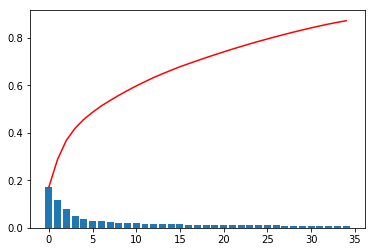

In [29]:
# Investigate the variance accounted for by each principal component.
cumvals = np.cumsum(pca.explained_variance_ratio_[:35])
plt.bar(range(35),pca.explained_variance_ratio_[:35])
plt.plot(range(35),cumvals,c='r')
print('The top 35 components contribute to {:.2f}% variance'.format(cumvals[-1]*100))

In [30]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_35 = PCA(n_components=35)
pca_35.fit(azdias_clean_scaled)

PCA(copy=True, iterated_power='auto', n_components=35, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [31]:
azdias_pca = pca_35.transform(azdias_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

The first 35 components contribute over 88% of total variance and thus I retain the first 35 components as the principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [32]:
def comp_feat(components,features,n):
    comp = components[n]
    comp_feat_df = pd.DataFrame({'features': features,'components': comp})
    comp = comp_feat_df.sort_values(by='components',ascending=False)
    comp.sort_values(by='components',ascending=False).plot(kind='bar',x='features',y='components',figsize=(16,8))
    return comp

    components            features
66    0.203349          PLZ8_ANTG3
49    0.197284     CAMEO_DEUG_2015
67    0.197019          PLZ8_ANTG4
76    0.193855              wealth
39    0.193461  HH_EINKOMMEN_SCORE
    components           features
3    -0.198600  FINANZ_MINIMALIST
64   -0.204113         PLZ8_ANTG1
60   -0.204536         MOBI_REGIO
16   -0.215353     LP_STATUS_GROB
15   -0.217270     LP_STATUS_FEIN


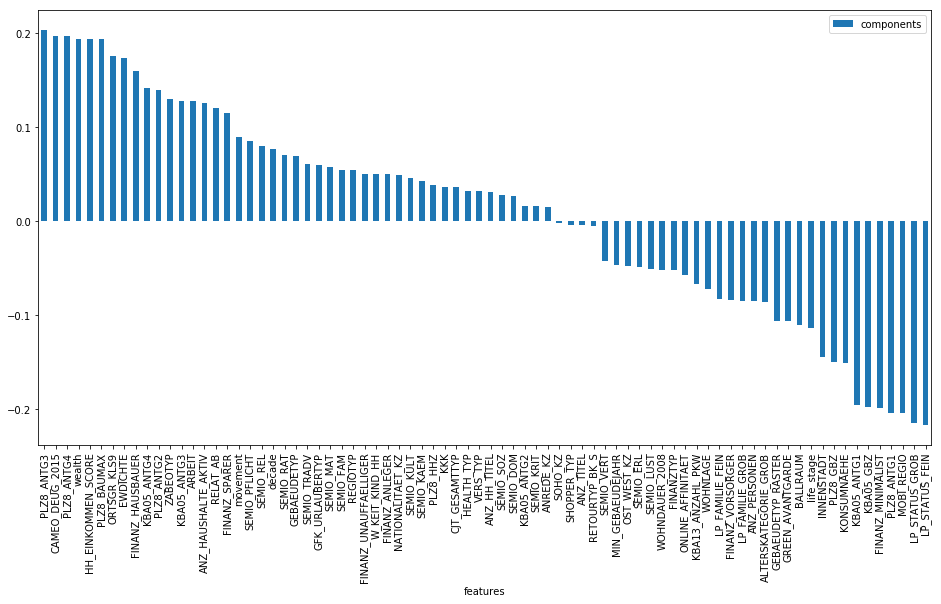

In [33]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

comp_first = comp_feat(pca_35.components_,azdias_clean.columns, 0)
print(comp_first.head())
print(comp_first.tail())

    components              features
0     0.263172  ALTERSKATEGORIE_GROB
5     0.236117      FINANZ_VORSORGER
25    0.223214             SEMIO_ERL
24    0.182735            SEMIO_LUST
18    0.161863        RETOURTYP_BK_S
    components               features
7    -0.231787  FINANZ_UNAUFFAELLIGER
31   -0.233491          SEMIO_PFLICHT
4    -0.245600          FINANZ_SPARER
74   -0.247124                 decade
21   -0.255647              SEMIO_REL


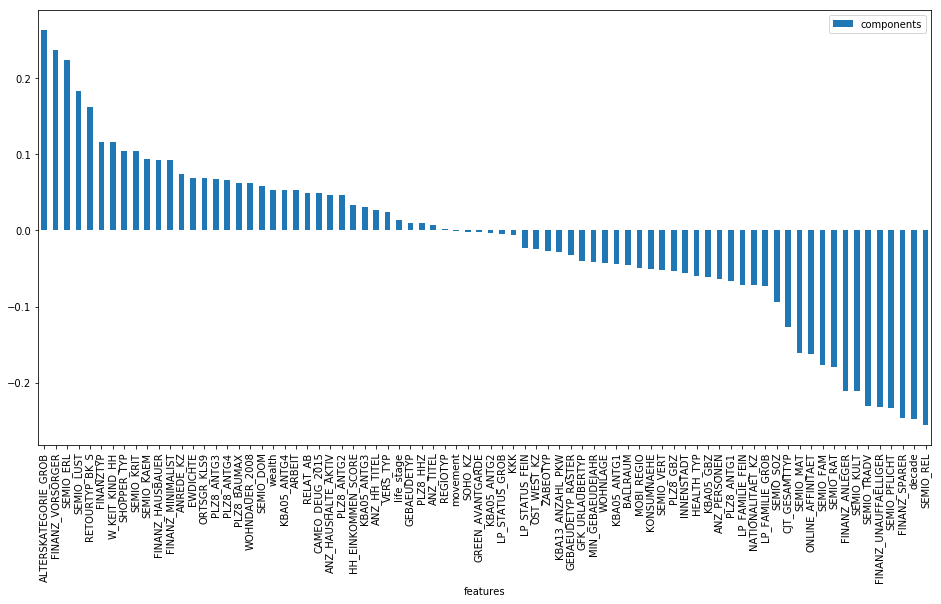

In [34]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_second = comp_feat(pca_35.components_,azdias_clean.columns, 1)
print(comp_second.head())
print(comp_second.tail())

    components           features
23    0.337676         SEMIO_VERT
19    0.260301          SEMIO_SOZ
20    0.255032          SEMIO_FAM
26    0.242610         SEMIO_KULT
3     0.149774  FINANZ_MINIMALIST
    components    features
27   -0.200102   SEMIO_RAT
28   -0.273805  SEMIO_KRIT
29   -0.308444   SEMIO_DOM
30   -0.333025  SEMIO_KAEM
1    -0.363739   ANREDE_KZ


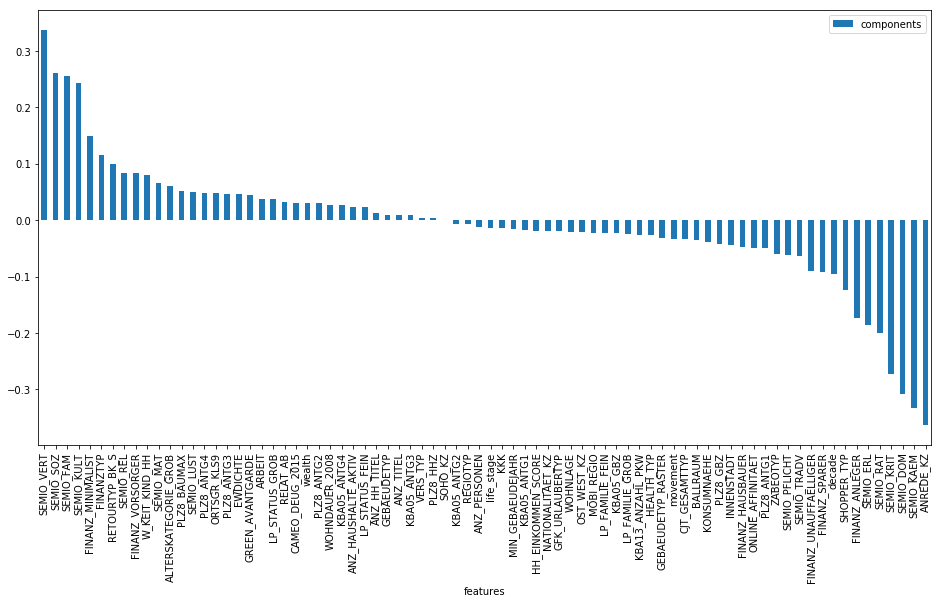

In [35]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_third = comp_feat(pca_35.components_,azdias_clean.columns, 2)
print(comp_third.head())
print(comp_third.tail())

### Discussion 2.3: Interpret Principal Components

For component 0, the top 3 positive and negative related features are:  
positive features: PLZ8_ANTG3 CAMEO_DEUG_2015 PLZ8_ANTG4    
negative features: MOBI_REGIO LP_STATUS_GROB LP_STATUS_FEIN  
According to the dictionary, we know that component 0 is related to people's financial situation. Be specific, it is proportional with the value of 'PLZ8_ANTG3', 'CAMEO_DEUG_2015', 'PLZ8_ANTG4'. The higher score, which means an unfortunate situation, could contribute more to component 0. While it is inversely proportional to 'MOBI_REGIO', 'LP_STATUS_GROB', 'LP_STATUS_FEIN', that means a wealthy condition contribute negatively.

For component 1, the top 3 positive and negative related features are:  
positive features: ALTERSKATEGORIE_GROB FINANZ_VORSORGER SEMIO_ERL  
negative features: FINANZ_SPARER decade SEMIO_REL  
Component 1 is connected to the people's age and personality. Elder people have a positive contribution. This component also favourite people would like or be prepared to invest in some events.

For component 2, the top 3 positive and negative related features are:  
positive features: SEMIO_VERT SEMIO_SOZ SEMIO_FAM  
negative features: SEMIO_DOM SEMIO_KAEM ANREDE_KZ  
This component cares about the personality and gender. The 'dreamful', 'socially-minded' and 'family-minded' features contribute positively, While 'dominant-minded', 'combative attitude' male contribute negatively.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. 

In [36]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
scores = []
for n in range(10,30,2):
    km = KMeans(n_clusters=n)
    km.fit(azdias_pca)
    label = km.predict(azdias_pca)
    scores.append(km.score(azdias_pca)*(-1))

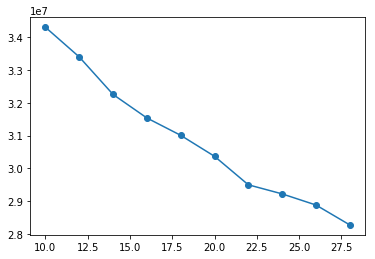

In [37]:
# Investigate the change in within-cluster distance across number of clusters.
plt.plot(range(10,30,2),scores,marker='o');

In [49]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start = time.time()
n = 10
km = KMeans(n_clusters=n,random_state=32)
km.fit(azdias_pca)
general_cluster = km.predict(azdias_pca)
end = time.time()
print(end-start)

123.78342199325562


### Discussion 3.1: Apply Clustering to General Population

With the number of clusters increase, the score reduced. I choose cluster number: 22,15,10 to investigate the final results. I find that the there are more under presented clusters when the number of clusters is big (22,15). I further study the major components of these under presented clusters and found that most major positive and negative components are similar. I decided to combine these under-presented groups and choose 10 as the final cluster number.

### Step 3.2: Apply All Steps to the Customer Data

In [50]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [51]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
(customers_clean.isnull().sum(axis=0).sort_values(ascending=False)/customers_clean.shape[0])[:10]

life_stage    0.0
SEMIO_KRIT    0.0
SEMIO_REL     0.0
SEMIO_MAT     0.0
SEMIO_VERT    0.0
SEMIO_LUST    0.0
SEMIO_ERL     0.0
SEMIO_KULT    0.0
SEMIO_RAT     0.0
SEMIO_DOM     0.0
dtype: float64

In [52]:
customers_clean_scaled = scaler.transform(customers_clean)
customers_pca = pca_35.transform(customers_clean_scaled)
customer_cluster = km.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

In [53]:
#add the data point seperated from step 1.1.3 as new cluster
missing_general = azdias.isnull().sum(axis=1)
missing_customers = customers.isnull().sum(axis=1)
general_new_cluster,_ = divide_rows(missing_general,20)
customer_new_cluster,_ = divide_rows(missing_customers,20)

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_df = pd.DataFrame({'general_cluster': general_cluster})
customer_df = pd.DataFrame({'customer_cluster': customer_cluster})
general_cluster_count = general_df.groupby('general_cluster').size()
customer_cluster_count = customer_df.groupby('customer_cluster').size()

In [55]:
propotions = pd.DataFrame()
propotions['general'] = general_cluster_count/(len(general_new_cluster)+general_df.shape[0])*100
propotions['customer'] = customer_cluster_count/(len(customer_new_cluster)+customer_df.shape[0])*100
propotions = propotions.append({
                   'general':len(general_new_cluster)/(len(general_new_cluster)+general_df.shape[0])*100,
                   'customer':len(customer_new_cluster)/(len(customer_new_cluster)+customer_df.shape[0])*100
                  },ignore_index=True)

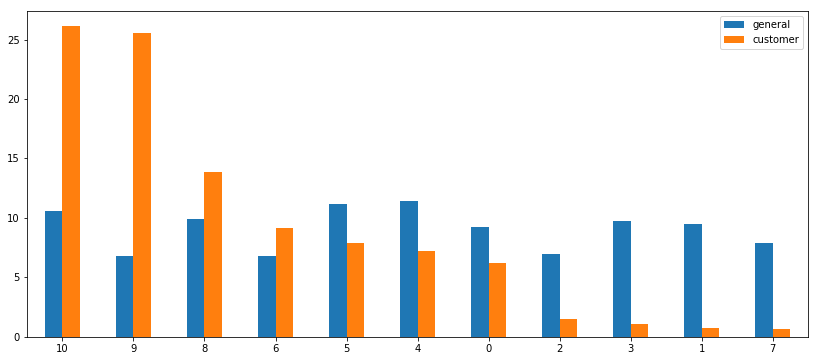

In [56]:
propotions.sort_values('customer',ascending=False).plot.bar(figsize=(14,6),rot=0);

In [66]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
general_idx = np.argwhere(general_cluster==9).flatten()
customer_idx = np.argwhere(customer_cluster==9).flatten()

In [67]:
general_pca_df = pd.DataFrame(data=azdias_pca,columns=range(35))
general_pca = general_pca_df.iloc[general_idx]
customers_pca_df = pd.DataFrame(data=customers_pca,columns=range(35))
customers_pca = customers_pca_df.iloc[customer_idx]

In [68]:
customers_pca.idxmax(axis=1).value_counts()[:3]

2    24220
3    16478
1     1601
dtype: int64

In [69]:
customers_pca.idxmin(axis=1).value_counts()[:3]

0     42345
24     1397
4      1310
dtype: int64

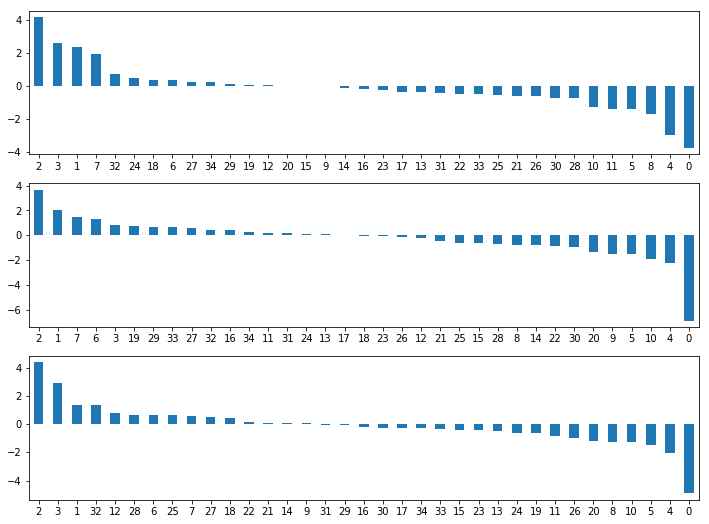

In [70]:
fig,axes = plt.subplots(3,1,figsize=(12,9))
customer_sample = customers_pca.sample(3)
for i in range(3):
    customer_sample.iloc[i].sort_values(ascending=False).plot.bar(rot=0,ax=axes[i])

In [71]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
customer_idx = np.argwhere(customer_cluster==7).flatten()
customers_pca = customers_pca_df.iloc[customer_idx]

In [72]:
customers_pca.idxmax(axis=1).value_counts()[:3]

0    802
2    243
3     99
dtype: int64

In [73]:
customers_pca.idxmin(axis=1).value_counts()[:3]

1    569
9    191
5     54
dtype: int64

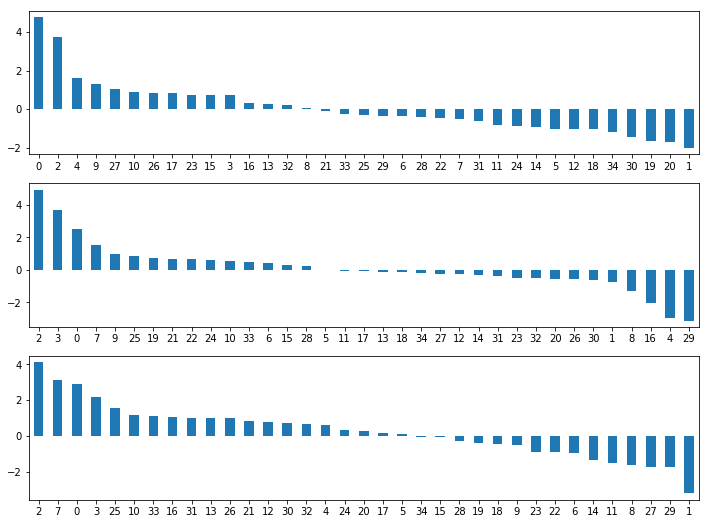

In [74]:
fig,axes = plt.subplots(3,1,figsize=(12,9))
customer_sample = customers_pca.sample(3)
for i in range(3):
    customer_sample.iloc[i].sort_values(ascending=False).plot.bar(rot=0,ax=axes[i])

### Discussion 3.3: Compare Customer Data to Demographics Data

I choose the over-presented cluster 9 and under-presented cluster 7. By analysing the importance of the components, I find that the components 2 and 3 are the dominant positive components of group 9 while component 0 is the major negative component. Then I evaluate the component 2 and 0 and find that the person is 'dreamful','socially-minded', 'family-minded' wealthy female is the popular customer of the company. For cluster 7, the major positive component is 0 while the top negative component is 1, which is opposite of the cluster 9. The company would not like to consider the young people having no investment experience in the unfortunate financial situation as their potential customer.